In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pvlib
print(pvlib.__version__)

0.9.1


In [3]:
import datetime
from tqdm import tqdm

# Modèle

In [4]:
# POA geometry definition

tilts = {
    'horizontal_tilt_0' : 0.0,
    'optimum_tilt_37' : 37.0
}

modele = {
    'lieu' : 'Pechbusque',
    'azimuth' : 180.0,
    'tilts' : tilts,
    'tilt_choisi' : 'horizontal_tilt_0',
    'modele_temperature' : 'close_mount_glass_glass', # parmi ['open_rack_glass_glass', 'close_mount_glass_glass', 'open_rack_glass_polymer', 'insulated_back_glass_polymer']
    'dc_installed' : 18 * 405.0, # puissance crete installée
    'AC_onduleur' : 6000.0, # puissance onduleur VA
    'rendement_onduleur' : 0.98,
}

# METEO à Toulouse

In [5]:
# where is Pechbusque...
# name,latitude, longitude, altitude, timezone

coordinates = {
    'Pechbusque': (43.515, 1.465, 279.0, 'Europe/Paris'),
    'Montpellier' : (43.58, 3.97, 6.0, 'Europe/Paris')   # pour comparer avec PV Watts
}

In [6]:
lieu = modele.get('lieu')

In [7]:
latitude, longitude, altitude, time_zone = coordinates[lieu]

In [8]:
# récupère infos de PV-GIS

df_weather, months, inputs, metadata = pvlib.iotools.get_pvgis_tmy(latitude=latitude,
                                                                   longitude=longitude,
                                                                   map_variables=True
                                                                   )

In [9]:
df_weather.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
temp_air,8760.0,15.158910,7.127826,-4.49,10.1600,15.00,20.0700,37.21
relative_humidity,8760.0,76.830857,16.476023,27.07,65.0675,80.30,90.8425,100.00
ghi,8760.0,155.585919,239.517266,0.00,0.0000,0.00,240.0125,993.00
dni,8760.0,157.239387,271.987149,0.00,0.0000,0.00,211.5850,1032.41
dhi,8760.0,69.294155,98.825464,0.00,0.0000,0.00,119.0000,468.00
IR(h),8760.0,304.853515,45.508030,186.55,270.0300,304.89,343.9000,407.80
wind_speed,8760.0,3.301823,1.907680,0.04,1.8800,2.79,4.4500,11.50
wind_direction,8760.0,252.021005,79.288235,0.00,185.0000,291.00,315.0000,360.00
pressure,8760.0,98577.318037,777.685085,95662.00,98103.0000,98568.00,99068.0000,100770.00


In [10]:
df_weather.head(5)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2005-01-01 00:00:00+00:00,9.12,98.04,0.0,0.0,0.0,282.64,1.94,304.0,99986.0
2005-01-01 01:00:00+00:00,9.02,98.05,0.0,0.0,0.0,276.86,2.08,304.0,99986.0
2005-01-01 02:00:00+00:00,8.92,98.06,0.0,0.0,0.0,271.09,2.23,304.0,99986.0
2005-01-01 03:00:00+00:00,8.82,98.07,0.0,0.0,0.0,265.31,2.37,304.0,99964.0
2005-01-01 04:00:00+00:00,8.72,98.08,0.0,0.0,0.0,259.54,2.51,304.0,99941.0


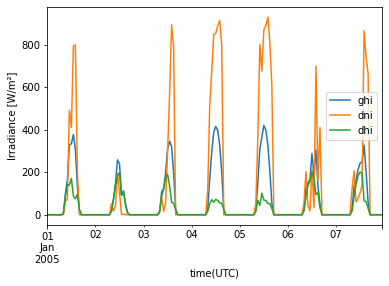

In [11]:
# Irradiance

first_week = df_weather.head(24*7)  # Plotting 7 days, each one has 24 hours or entries
first_week[['ghi', 'dni', 'dhi']].plot()
plt.ylabel('Irradiance [W/m²]')
plt.show()

In [12]:
print(f"{lieu}")
print(f"GHI annuel : {df_weather['ghi'].sum()/1000:.0f} kWh/m²/an")
print(f"DNI annuel : {df_weather['dni'].sum()/1000:.0f} kWh/m²/an")
print(f"DHI annuel : {df_weather['dhi'].sum()/1000:.0f} kWh/m²/an")

Pechbusque
GHI annuel : 1363 kWh/m²/an
DNI annuel : 1377 kWh/m²/an
DHI annuel : 607 kWh/m²/an


In [13]:
# travail sur le format : on force tous les timestamps pour avoir la même année : 2023

new_index_to_2023 = [ datetime.datetime(2023, d.month, d.day, d.hour, d.minute, tzinfo=d.tzinfo) for d in df_weather.index ]
new_index_to_2023 = pd.DatetimeIndex(new_index_to_2023)

df_weather = df_weather.set_index(new_index_to_2023)

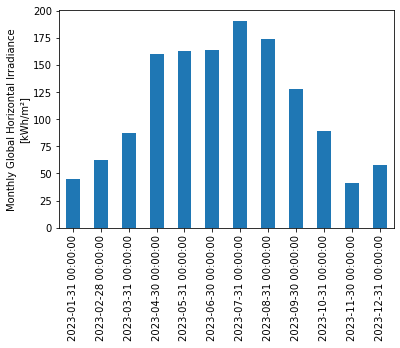

In [14]:
# données mensuelles

monthly_ghi = df_weather['ghi'].resample('M').sum()/1000  # NB : nécessite d'avoir la même année, sinon le resampling produit plus de 12 lignes
monthly_ghi = monthly_ghi.tz_localize(None)  # pour afficher sans la tz

monthly_ghi.plot.bar()

plt.ylabel('Monthly Global Horizontal Irradiance\n[kWh/m²]');

# POA Irradiance

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%202%20-%20POA%20Irradiance.html

In [15]:
# instancie un objet Location de pvlib

location = pvlib.location.Location(latitude=latitude,
                                   longitude=longitude,
                                   altitude=altitude,
                                   name=lieu,
                                   tz=time_zone
)

In [16]:
# calcul de la position du soleil, au milieu (30 mins) de chaque intervalle horaire

times = df_weather.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2023-01-01 00:00:00+00:00,158.765032,158.765032,-68.765032,-68.765032,342.413453,-3.177534
2023-01-01 01:00:00+00:00,158.443328,158.443328,-68.443328,-68.443328,20.835977,-3.197268
2023-01-01 02:00:00+00:00,152.008806,152.008806,-62.008806,-62.008806,50.456864,-3.216993
2023-01-01 03:00:00+00:00,142.579424,142.579424,-52.579424,-52.579424,69.325124,-3.236709
2023-01-01 04:00:00+00:00,132.038408,132.038408,-42.038408,-42.038408,82.546649,-3.256415


In [17]:
# POA geometry definition

tilts = modele.get('tilts')
azimuth = modele.get('azimuth')

In [18]:
# calcule les valeurs horaires de l'irradiance POA pour les différents tilts

dfs_poa ={}

for k,tilt in tilts.items():
    dfs_poa[k] = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=df_weather['dni'],
        ghi=df_weather['ghi'],
        dhi=df_weather['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic'
    )

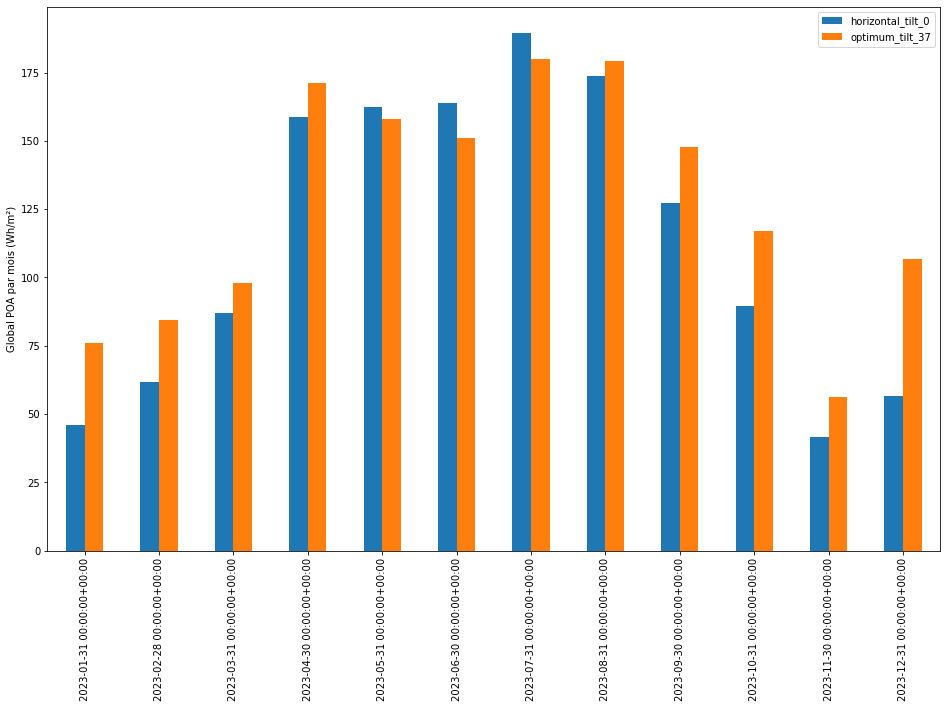

In [19]:
data_global_poa = { k : dfs_poa.get(k)['poa_global'] for k in tilts.keys() }

for k, df in dfs_poa.items():
    df_monthly = df.resample('M').sum()/1000.0
    data_global_poa[k] = df_monthly['poa_global']
    
df_summary = pd.DataFrame(data_global_poa)

df_summary = df_summary.resample('M').sum()

fig, ax = plt.subplots(figsize=(16,10))
df_summary.plot.bar(ax = ax)
plt.ylabel('Global POA par mois (Wh/m²)')
plt.show()

In [20]:
for tilt_config, df in dfs_poa.items():
    print(f"\n{tilt_config}")
    print(f"POA global annuel = {df['poa_global'].sum()/1000:.0f} kWh/m² ")


horizontal_tilt_0
POA global annuel = 1357 kWh/m² 

optimum_tilt_37
POA global annuel = 1526 kWh/m² 


In [21]:
# This plot shows that, compared with a flat array, a tilted array receives significantly more insolation in the winter.
# However, it comes at the cost of slightly less insolation in the summer. 
# The difference is all about solar position – tilting up from horizontal gives a better match to solar position in winter, when the sun is low in the sky. 
# However it gives a slightly worse match in summer when the sun is very high in the sky.

# Choix CONFIG

In [22]:
tilt_choisi = modele.get('tilt_choisi')

# Module Temperature

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%203%20-%20Module%20Temperature.html

In [23]:
# On a déjà les données météo pour différents tilts,
# il faut maintenant le modèle de température

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

# descriptions ici : https://sam.nrel.gov/forum/forum-general/1040-mount-types.html#:~:text=Cell%2FPolymer%20Sheet-,Open%20Rack,Open%20Rack
# ""Roof mount is typical of residential installations where modules are attached to the roof surface with standoffs that providing limited air flow between the module back and roof surface (typically between two and six inches).""

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [24]:
methode = modele.get('modele_temperature')

parameters = all_parameters[methode]   # approprié pour les fixations à tilt = 0° (Dome Solar)

In [25]:
cell_temperature = pvlib.temperature.sapm_cell(
    dfs_poa.get(tilt_choisi)['poa_global'],   # valeurs horaires de l'irradiance sur POA
    df_weather['temp_air'],
    df_weather['wind_speed'],
    **parameters
)

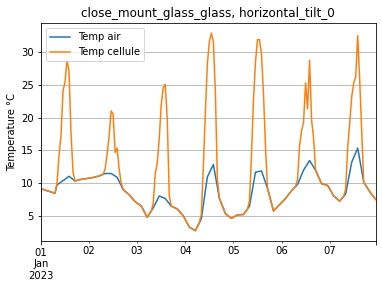

In [26]:
df_weather['temp_air'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Temp air', 'Temp cellule'])
plt.ylabel('Temperature °C')
plt.title(f"{methode}, {tilt_choisi}")
plt.show()

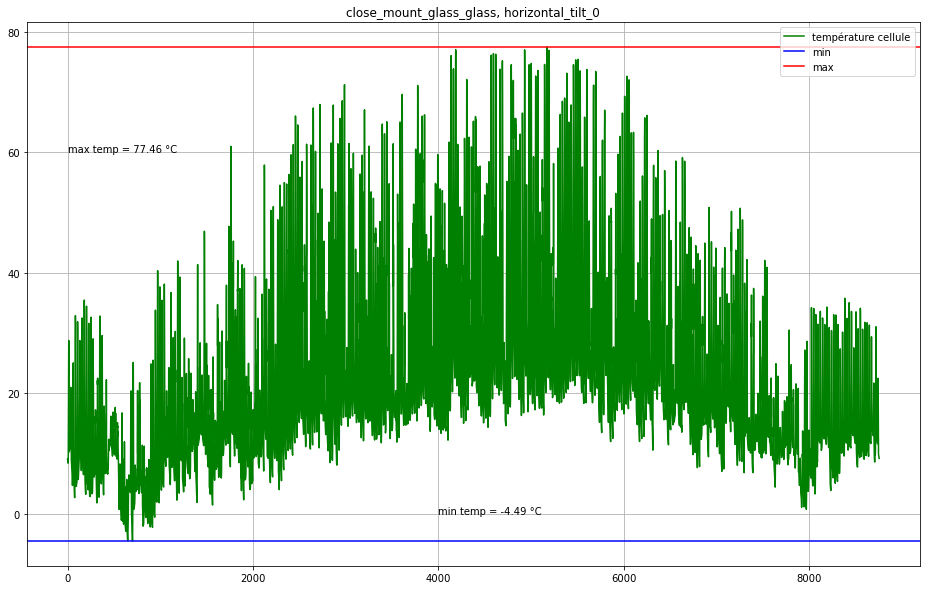

In [27]:
methode = modele.get('modele_temperature')
tilt_choisi = modele.get('tilt_choisi')

cell_temp_min = cell_temperature.min()
cell_temp_max = cell_temperature.max()

temp = np.array(cell_temperature)

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(temp, color='g', label='température cellule')

plt.axhline(y=cell_temp_min, color='b', label='min')
plt.text(4000,0,f"min temp = {cell_temp_min:.2f} °C")

plt.axhline(y=cell_temp_max, color='r', label='max')
plt.text(0,60,f"max temp = {cell_temp_max:.2f} °C")

plt.title(f"{methode}, {tilt_choisi}")

plt.legend()
plt.grid()
plt.show()

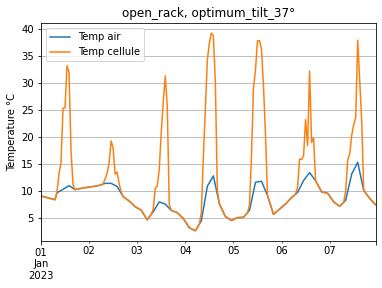

In [28]:
parameters = all_parameters['open_rack_glass_glass']   # what if... fixation à 37°C

cell_temperature = pvlib.temperature.sapm_cell(
    dfs_poa.get('optimum_tilt_37')['poa_global'],   # valeurs horaires de l'irradiance sur POA
    df_weather['temp_air'],
    df_weather['wind_speed'],
    **parameters
)

df_weather['temp_air'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Temp air', 'Temp cellule'])
plt.ylabel('Temperature °C')
plt.title(f"open_rack, optimum_tilt_37°")
plt.show()

# NB : meilleur refroidissment supposé, mais un peu plus de Watts, donc ça chauffe plus ?

# Module Performance

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%204%20-%20Model%20a%20Module%27s%20Performance.html

In [29]:
# Standard Test Conditions

E0 = 1000.0 # W/m²
T0 = 25.0 # 0°C

# IEC61853 Test Matrix
E_IEC61853 = [100, 200, 400, 600, 800, 1000, 1100]  # irradiances [W/m^2]
T_IEC61853 = [15, 25, 50, 75]  # temperatures [degC]

IEC61853 = np.meshgrid(T_IEC61853, E_IEC61853)

# IEC61853

In [30]:
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

CECMODS.T.columns

Index(['Technology', 'Bifacial', 'STC', 'PTC', 'A_c', 'Length', 'Width', 'N_s',
       'I_sc_ref', 'V_oc_ref', 'I_mp_ref', 'V_mp_ref', 'alpha_sc', 'beta_oc',
       'T_NOCT', 'a_ref', 'I_L_ref', 'I_o_ref', 'R_s', 'R_sh_ref', 'Adjust',
       'gamma_r', 'BIPV', 'Version', 'Date'],
      dtype='object')

In [31]:
trina_mods = CECMODS.T.index.str.startswith('Trina_Solar') & CECMODS.T.index.str.contains('TSM_375')
CECMODS.T[trina_mods]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Trina_Solar_TSM_375DE14A_II_,Mono-c-Si,0,374.8,348.8,1.92,NaN,NaN,72,9.88,48.5,...,1.818712,9.884084,0.0,0.311839,754.506287,7.608252,-0.372,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DE14H_II_,Mono-c-Si,0,375.088,349.8,1.96,NaN,NaN,48,9.93,47.8,...,1.777433,10.033036,0.0,0.308714,828.678345,5.118076,-0.353,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DEG14_II_,Mono-c-Si,0,375.6,349.6,1.96,NaN,NaN,72,9.71,47.5,...,1.837296,9.908375,0.0,0.194844,602.328247,14.726869,-0.378,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DEG14_40_II_,Mono-c-Si,0,375.6,349.6,1.96,NaN,NaN,72,9.71,47.5,...,1.837296,9.908375,0.0,0.194844,602.328247,14.726869,-0.378,N,SAM 2018.11.11 r2,1/3/2019


In [32]:
# CECMODS.T[trina_mods].mean().T

In [33]:
#-----------------------------------------------------------------------------------------------------
# données module Trina : sources = datasheet Trina, base CEC, autres info reprises de la db SAM
#-----------------------------------------------------------------------------------------------------

module_trina_vertex_405_CEC = {
    'Technology' : 'Mono-c-Si',
    'A_c' : 1.91,
    'N_s' : 60, # nb cells en série
    'N_p' : 2, # nb strings cells en paralèlle
    'I_sc_ref' : 12.34, # I court circuit
    'V_oc_ref' : 41.4, # V open circuit
    'I_mp_ref' : 11.77, # I max power
    'V_mp_ref' : 34.4, # V max power
    'T_NOCT' : 44.8, # Temperature NOC
    'gamma_r' : -0.357, # power temperature coefficient at reference condition in %/Δ°C
    'alpha_sc' : 0.033, # short circuit current temperature coefficient in A/Δ°C
    'beta_oc' : -0.266, # open circuit voltage temperature coefficient in V/Δ°C
    'a_ref' : 1.817684, # diode ideality factor - reuse TSM-375W average
    'I_L_ref' : 9.933467,  # light or photogenerated current at reference condition in A - reuse 375W average
    'I_o_ref' : 4.073428e-11, # diode saturation current at reference condition in A - reuse 375W average
    'R_s' : 0.2525602, # series resistance in Ω - reuse 375W average
    'R_sh_ref' : 696.9603, # shunt resistance at reference condition in Ω - reuse 375W average
    'Adjust' : 10.54502, # adjustment to short circuit temperature coefficient in % - reuse 375W average
    'BIPV' : 'N',  
    'PTC' : 378.0,
    'STC' : 405.0,
    'Length' : 1.754,
    'Width' : 1.096,
    "Name" : "Trina_Vertex_405Wc_TSM-DE09"
}

In [34]:
# calcul des Single Diod Parameters aux différents points du test IEC (T°C cell x irradiance)
# afin de pouvoir inférer les courbes I-V à différentes conditions

temp_cell, effective_irradiance = IEC61853

cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=effective_irradiance,
        temp_cell=temp_cell,
        alpha_sc=module_trina_vertex_405_CEC.get('alpha_sc'),
        a_ref=module_trina_vertex_405_CEC.get('a_ref'),
        I_L_ref=module_trina_vertex_405_CEC.get('I_L_ref'),
        I_o_ref=module_trina_vertex_405_CEC.get('I_o_ref'),
        R_sh_ref=module_trina_vertex_405_CEC.get('R_sh_ref'),
        R_s=module_trina_vertex_405_CEC.get('R_s'),
        Adjust=module_trina_vertex_405_CEC.get('Adjust'),
        EgRef=1.121,
        dEgdT=-0.0002677)

IL, I0, Rs, Rsh, nNsVth = cecparams

In [35]:
# flatten the meshgrid to allow single diode to broadcast the output

curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL.flatten(),
    saturation_current=I0.flatten(),
    resistance_series=Rs,
    resistance_shunt=Rsh.flatten(),
    nNsVth=nNsVth.flatten(),
    ivcurve_pnts=101,
    method='lambertw')

# display the max power points
# curve_info['p_mp']

In [36]:
curve_info.keys()

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])

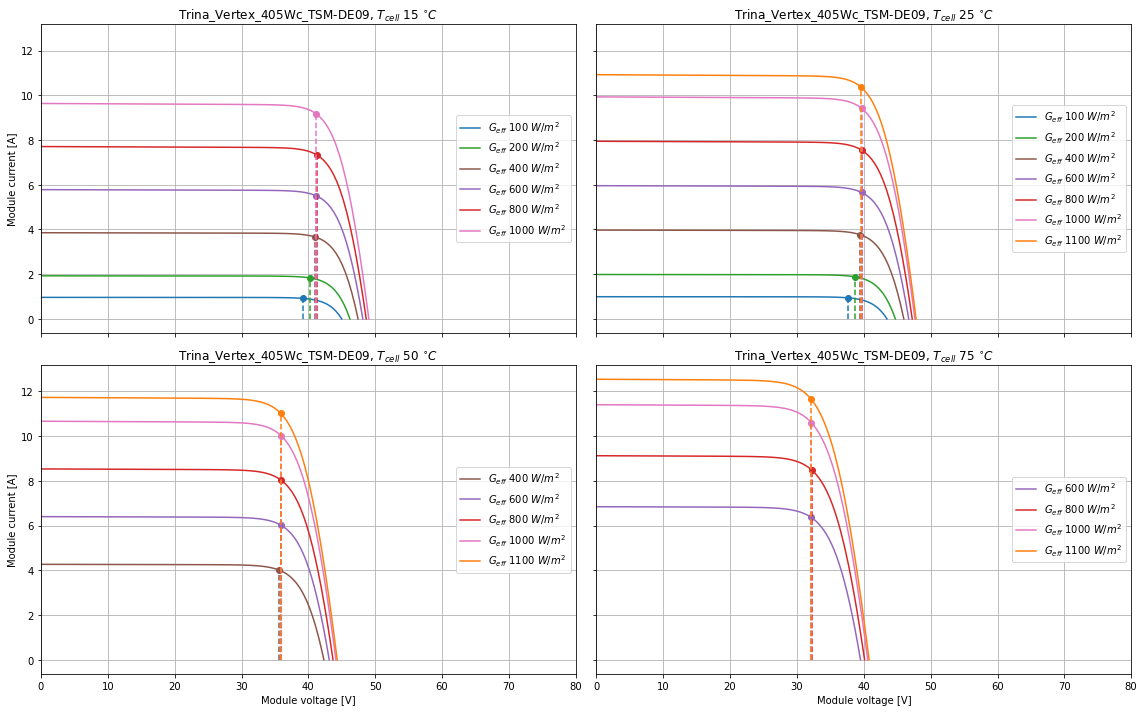

In [37]:
# plot the calculated curves:

exclude = [(1100, 15), (400, 75), (200, 50), (200, 75), (100, 50), (100, 75)]
kolor = ['#1f77b4', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#ff7f0e']

f, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for m, irr in enumerate(E_IEC61853):
    for n, tc in enumerate(T_IEC61853):
        if (irr, tc) in exclude:
            continue
        i = n + 4*m
        j = n // 2, n % 2
        label = (
            "$G_{eff}$ " + f"{irr} $W/m^2$"
        )
        ax[j].plot(curve_info['v'][i], curve_info['i'][i], label=label, c=kolor[m])
        v_mp = curve_info['v_mp'][i]
        i_mp = curve_info['i_mp'][i]
        # mark the MPP
        ax[j].plot(v_mp, i_mp, ls='', marker='o', c=kolor[m])
        ax[j].vlines(v_mp, 0, i_mp, linestyle='dashed', color=kolor[m])
        # just repeat this every time doesn't hurt anyone
        ax[j].legend(loc='right')
        if j[0] == 1:
            ax[j].set_xlabel('Module voltage [V]')
        if j[1] == 0:
            ax[j].set_ylabel('Module current [A]')
        ax[j].set_title(f"{module_trina_vertex_405_CEC.get('Name')}, " + "$T_{cell}$ " + f"{tc} " + "$^{\circ}C$")
        ax[j].grid(True)
        ax[j].set_xlim([0, 80])

f.tight_layout()

# Array Power

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%205%20-%20Array%20Power.html

In [38]:
gamma_pdc = module_trina_vertex_405_CEC.get('gamma_r')/100.0
nameplate = modele.get('dc_installed') # puissance crete installée

In [39]:
array_power = pvlib.pvsystem.pvwatts_dc(
    dfs_poa.get(tilt_choisi)['poa_global'], 
    cell_temperature, 
    nameplate, 
    gamma_pdc,
    )

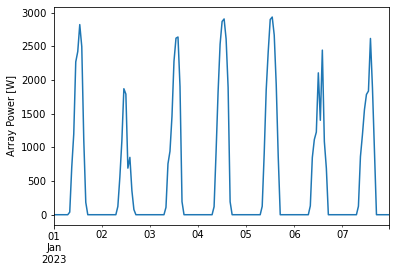

In [40]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

In [41]:
print(f"DC Power annuel pour {tilt_choisi} : {array_power.sum()/1000.0:.0f} kWh")

DC Power annuel pour horizontal_tilt_0 : 9445 kWh


# AC/DC ... forcément ...

In [42]:
# Modèle simpliste onduleur

ac0 = modele.get('AC_onduleur') # puissance onduleur VA
eta = modele.get('rendement_onduleur') # 0.98 # rendement
pdc0 = ac0/eta  # puissance nominale DC

ac = pvlib.inverter.pvwatts(array_power, pdc0)

In [43]:
array_power

2023-01-01 00:00:00+00:00    0.0
2023-01-01 01:00:00+00:00    0.0
2023-01-01 02:00:00+00:00    0.0
2023-01-01 03:00:00+00:00    0.0
2023-01-01 04:00:00+00:00    0.0
                            ... 
2023-12-31 19:00:00+00:00    0.0
2023-12-31 20:00:00+00:00    0.0
2023-12-31 21:00:00+00:00    0.0
2023-12-31 22:00:00+00:00    0.0
2023-12-31 23:00:00+00:00    0.0
Length: 8760, dtype: float64

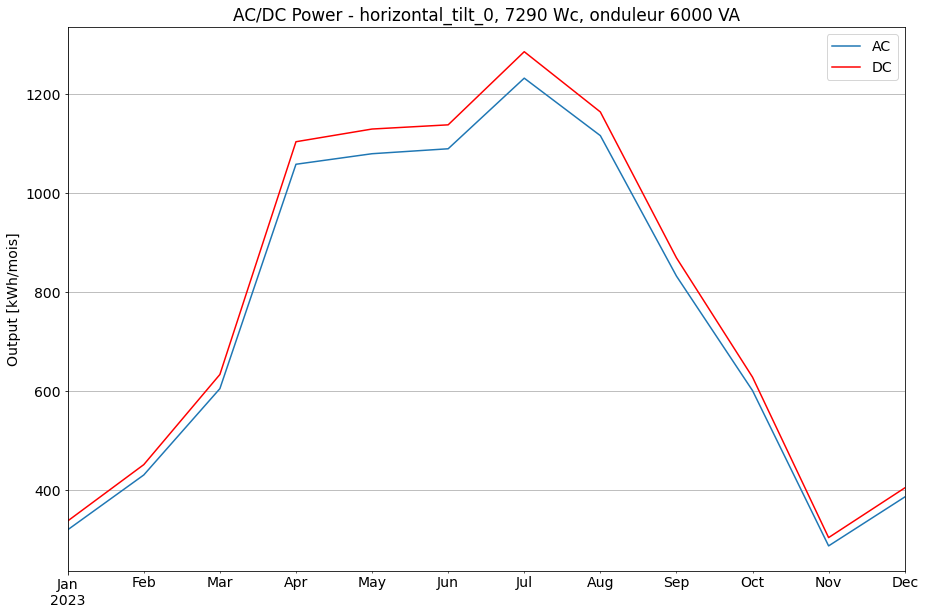

In [44]:
plt.rcParams['font.size'] = 14

ac_period = ac.resample('M').sum()/1000.0
dc_period = array_power.resample('M').sum()/1000.0

ax = ac_period.plot(figsize=(15, 10), label='AC')
dc_period.plot(ax=ax, label='DC', color='r')

plt.title(f'AC/DC Power - {tilt_choisi}, {nameplate:.0f} Wc, onduleur {ac0:.0f} VA')
plt.ylabel('Output [kWh/mois]')

plt.grid()
plt.legend()
plt.show()

In [45]:
print (f"Modèle = {tilt_choisi}")
print (f"méthode montage = {methode}")
print (f"Puissance DC = {nameplate:.0f} Wc")
print (f"Puissance onduleur = {ac0:.0f} kVA, rendement = {eta:.1%}")
print (f"Prod AC totale annuelle = {ac.sum()/1000:.0f} kWh")
print (f"Ensoleillement total POA = {dfs_poa.get(tilt_choisi)['poa_global'].sum()/1000.0:.0f} kWh/m²")

Modèle = horizontal_tilt_0
méthode montage = close_mount_glass_glass
Puissance DC = 7290 Wc
Puissance onduleur = 6000 kVA, rendement = 98.0%
Prod AC totale annuelle = 9034 kWh
Ensoleillement total POA = 1357 kWh/m²


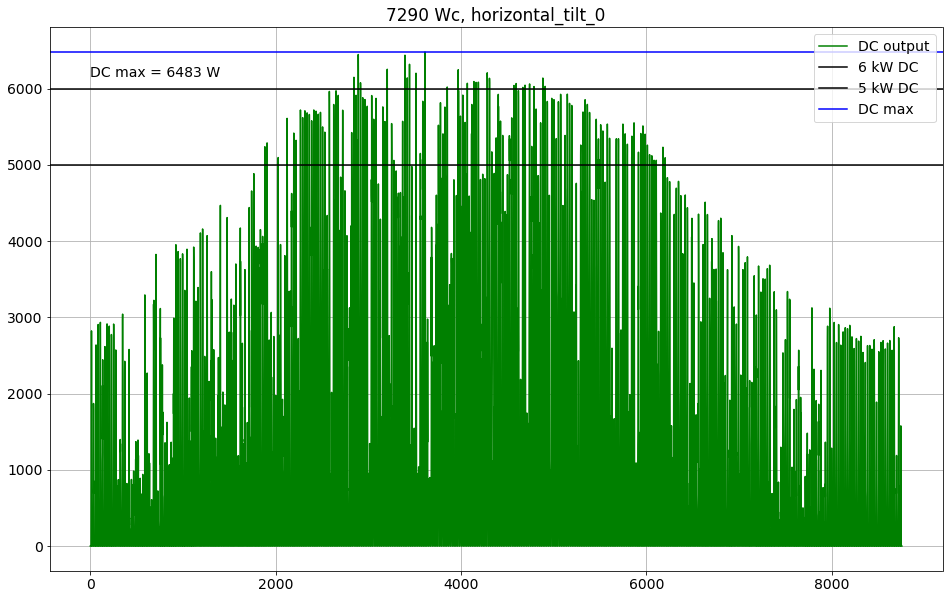

In [46]:
dc_max = array_power.max()

dc_hourly = np.array(array_power)

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(dc_hourly, color='g', label='DC output')

plt.axhline(y=6000.0, color='k', label='6 kW DC')

plt.axhline(y=5000.0, color='k', label='5 kW DC')

plt.axhline(y=dc_max, color='b', label='DC max')
plt.text(0, dc_max * .95,f"DC max = {dc_max:.0f} W")

plt.title(f"{nameplate:.0f} Wc, {tilt_choisi}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

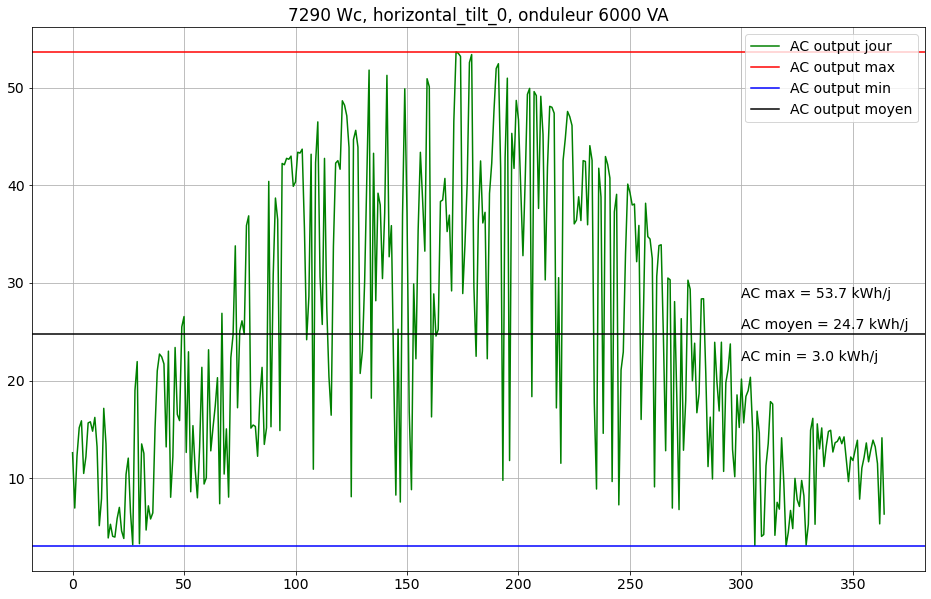

In [47]:
ac_period = ac.resample('D').sum()/1000.0

ac_max = ac_period.max()
ac_min = ac_period.min()
ac_mean = ac_period.mean()

ac_daily = np.array(ac_period)

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(ac_daily, color='g', label='AC output jour')

plt.axhline(y=ac_max, color='r', label='AC output max')
plt.text(300, ac_mean * 1.15,f"AC max = {ac_max:.1f} kWh/j")

plt.axhline(y=ac_min, color='b', label='AC output min')
plt.text(300, ac_mean * 0.89,f"AC min = {ac_min:.1f} kWh/j")

plt.axhline(y=ac_mean, color='k', label='AC output moyen')
plt.text(300, ac_mean * 1.02,f"AC moyen = {ac_mean:.1f} kWh/j")

plt.title(f"{nameplate:.0f} Wc, {tilt_choisi}, onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

# Profils consommation

In [48]:
# Scenarii globaux, consommations mensuelles

scenario_full_family = {
    "nom" : "famille_6p",
    "consommations" : {
        "chauffage" : [598.0, 274.0, 219.0, 53.0, 0, 0, 0, 0, 0, 30.0, 205.0, 578.0],
        "ecs_rdc" : [215.0, 186.0, 184.0, 145.0, 185.0, 149.0, 122.0, 156.0, 141.0, 171.0, 145.0, 232.0],
        "ecs_etg" : [178.0, 152.0, 161.0, 132.0, 167.0, 148.0, 90.0, 115.0, 123.0, 143.0, 125.0, 163.0],
        "vmc_df" : [286.0, 151.0, 119.0, 96.0, 89.0, 93.0, 95.0, 79.0, 89.0, 122.0, 117.0, 196.0],
        "elec_24_7" : [271.0, 245.0, 271.0, 262.0, 271.0, 262.0, 271.0, 271.0, 262.0, 271.0, 262.0, 271.0],  # constante jour x nb jours dans le mois
        "elec_autre" : [274.0] * 12,
        "piscine" : [60.0, 60.0, 60.0, 60.0, 360.0, 360.0, 360.0, 360.0, 360.0, 360.0, 60.0, 60.0],
        "ve1" : [198.0, 198.0, 180.0, 162.0, 144.0, 135.0, 75.0, 75.0, 135.0, 162.0, 180.0, 198.0],
        "ve2" : [198.0, 198.0, 180.0, 162.0, 144.0, 135.0, 75.0, 75.0, 135.0, 162.0, 180.0, 198.0]
        }
    }

scenario_deux_adultes = {
    "nom" : "deux_adultes",
    "consommations" : {
        "chauffage" : [598.0, 274.0, 219.0, 53.0, 0, 0, 0, 0, 0, 30.0, 205.0, 578.0],
        "ecs_rdc" : [215.0, 186.0, 184.0, 145.0, 185.0, 149.0, 122.0, 156.0, 141.0, 171.0, 145.0, 232.0],
        "ecs_etg" : [0.0] * 12,
        "vmc_df" : [286.0, 151.0, 119.0, 96.0, 89.0, 93.0, 95.0, 79.0, 89.0, 122.0, 117.0, 196.0],
        "elec_24_7" : [162.0, 146.0, 162.0, 157.0, 162.0, 157.0, 162.0, 162.0, 157.0, 162.0, 157.0, 162.0 ],  # constante jour x nb jours dans le mois
        "elec_autre" : [108.0] * 12,
        "piscine" : [60.0, 60.0, 60.0, 60.0, 360.0, 360.0, 360.0, 360.0, 360.0, 360.0, 60.0, 60.0],
        "ve1" : [99.0, 99.0, 90.0, 81.0, 72.0, 68.0, 38.0, 38.0, 68.0, 81.0, 90.0, 99.0],
        "ve2" : [99.0, 99.0, 90.0, 81.0, 72.0, 68.0, 38.0, 38.0, 68.0, 81.0, 90.0, 99.0]
        }
    }

In [49]:
# Profils hebdomadaires : modulation qui s'applique à elec_autre uniquement

semaine_actifs = {
    "nom" : "profil_hebdomadaire_actifs",
    "profil" : [ .11, .11, .16, .11, .11, .20, .20]
}

semaine_home_based = {
    "nom" : "profil_hebdomadaire_home_based",
    "profil" : [ 1.0/7 ] * 7
}

In [50]:
# profils consommations horaires

# chauffage ------------------------------------------------------------------------------------------------------------------------

split_dispo = [ x/100.0 for x in [ 10, 10, 10, 10, 10, 10, 10, 10, 10, 100, 100, 75, 75, 50, 25, 0, 0, 0, 25, 50, 75, 50, 50, 10] ]
s = sum(split_dispo)

profil_chauffage = [ x/s for x in split_dispo ]

# ECS as usual : pas de décalage de la conso pour matcher la production solaire ----------------------------------------------------

profil_ecs_as_usual = [ 1.0 / 24 ] * 24

# ECS solar-aware : décalage de la conso sur une plage horaire matchant la production solaire --------------------------------------

split_dispo = [0] * 13 + [100] * 5 + [0] * 6
split_dispo = [ x/100.0 for x in split_dispo ]
s = sum(split_dispo)

profil_ecs_solar_aware = [ x/s for x in split_dispo ]

# VMC DF ---------------------------------------------------------------------------------------------------------------------------

profil_vmc_df = [ 1.0 / 24 ] * 24

# Elec 24/7 ------------------------------------------------------------------------------------------------------------------------

profil_elec_24_7 = [ 1.0 / 24 ] * 24

# Elec autre -----------------------------------------------------------------------------------------------------------------------

split_dispo = [1,1,1,1,1,2,5,20,20,20,10,10,30,30,10,10,10,10,40,50,50,30,10,5]
split_dispo = [ x/100.0 for x in split_dispo ]
s = sum(split_dispo)

profil_elec_autre = [ x/s for x in split_dispo ]

# Piscine --------------------------------------------------------------------------------------------------------------------------

split_dispo = [0] * 9 + [100] * 12 + [0] * 3
split_dispo = [ x/100.0 for x in split_dispo ]
s = sum(split_dispo)

profil_piscine = [ x/s for x in split_dispo ]

# VE as usual ----------------------------------------------------------------------------------------------------------------------

profil_ve_as_usual = [ 1.0 / 24 ] * 24

# VE solar aware  ------------------------------------------------------------------------------------------------------------------

split_dispo = [0] * 12 + [100] * 6 + [0] * 6
split_dispo = [ x/100.0 for x in split_dispo ]
s = sum(split_dispo)

profil_ve_solar_aware = [ x/s for x in split_dispo ]

#----------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------

profil_as_usual = {
    "nom" : "pas_de_decalage_de_conso",
    "profils" : {
        "chauffage" : profil_chauffage,
        "ecs_rdc" : profil_ecs_as_usual,
        "ecs_etg" : profil_ecs_as_usual,
        "vmc_df" : profil_vmc_df,
        "profil_elec_24_7" : profil_elec_24_7,
        "profil_elec_autre" : profil_elec_autre,
        "piscine" : profil_piscine,
        "ve1" : profil_ve_as_usual,
        "ve2" : profil_ve_as_usual
        }
    }

profil_solar_aware = {
    "nom" : "decalage_consos",
    "profils" : {
        "chauffage" : profil_chauffage,
        "ecs_rdc" : profil_ecs_solar_aware,
        "ecs_etg" : profil_ecs_solar_aware,
        "vmc_df" : profil_vmc_df,
        "profil_elec_24_7" : profil_elec_24_7,
        "profil_elec_autre" : profil_elec_autre,
        "piscine" : profil_piscine,
        "ve1" : profil_ve_solar_aware,
        "ve2" : profil_ve_solar_aware
    }
}

In [51]:
# definition profil consommation global, par exemple :

scenario = {
    'consommations_mensuelles' : scenario_deux_adultes,
    'profil_hebdomadaire' : semaine_home_based,
    'profil_horaire' : profil_solar_aware
}

In [52]:
df = pd.DataFrame.from_dict(scenario.get('consommations_mensuelles').get('consommations'))
df

,chauffage,ecs_rdc,ecs_etg,vmc_df,elec_24_7,elec_autre,piscine,ve1,ve2
0,598.0,215.0,0.0,286.0,162.0,108.0,60.0,99.0,99.0
1,274.0,186.0,0.0,151.0,146.0,108.0,60.0,99.0,99.0
2,219.0,184.0,0.0,119.0,162.0,108.0,60.0,90.0,90.0
3,53.0,145.0,0.0,96.0,157.0,108.0,60.0,81.0,81.0
4,0.0,185.0,0.0,89.0,162.0,108.0,360.0,72.0,72.0
5,0.0,149.0,0.0,93.0,157.0,108.0,360.0,68.0,68.0
6,0.0,122.0,0.0,95.0,162.0,108.0,360.0,38.0,38.0
7,0.0,156.0,0.0,79.0,162.0,108.0,360.0,38.0,38.0
8,0.0,141.0,0.0,89.0,157.0,108.0,360.0,68.0,68.0
9,30.0,171.0,0.0,122.0,162.0,108.0,360.0,81.0,81.0


In [53]:
df.sum()

chauffage     1957.0
ecs_rdc       2031.0
ecs_etg          0.0
vmc_df        1532.0
elec_24_7     1908.0
elec_autre    1296.0
piscine       2520.0
ve1            923.0
ve2            923.0
dtype: float64

In [54]:
df.sum(axis=1)

0     1627.0
1     1123.0
2     1032.0
3      781.0
4     1048.0
5     1003.0
6      923.0
7      941.0
8      991.0
9     1115.0
10     972.0
11    1534.0
dtype: float64

### Construction du fichier horaire de consommations

In [55]:
# construction de "consommations_jour" : dictionnaire des consommations par jour : 9 rubriques (keys) x liste 365 valeurs (conso par jour)

consommations_mensuelles = scenario.get('consommations_mensuelles').get('consommations')  # dictionnaire des consommations mensuelles : 9 rubriques (keys) x liste 12 valeurs (conso par mois)

consommations_jour = { k : [] for k in consommations_mensuelles.keys() }

# nombre jours par mois

nb_jours_par_mois = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}

for rubrique, liste_consos in consommations_mensuelles.items():
    for m, conso_mois in enumerate(liste_consos):
        nb_jours_mois = nb_jours_par_mois.get(m+1)
        conso_jour = conso_mois / nb_jours_mois
        # print(f"{nb_jours_par_mois}")
        consommations_jour[rubrique].extend([conso_jour] * nb_jours_mois)

In [56]:
# construction de "consommations_jour_ponderees" : dictionnaire des consommations par jour pondérées du profil hebdomadaire : 9 rubriques (keys) x liste 365 valeurs (conso par jour)
# pour l'instant, cette pondération ne s'applique qu'à "elec_autre"
# les autres postes sont supposés indépendants du profil d'occupation de la maison

first_weekday_of_year = datetime.datetime.date(df_weather.index[0]).weekday()  # premier jour de l'année : en l'occurence, 6 (dimanche) en 2023.as_integer_ratio

grille_semaine = scenario.get('profil_hebdomadaire').get('profil')  # liste des %ages de la conso hebdo par jour de la semaine

rubriques_a_ponderer = ['elec_autre']

for rubrique in rubriques_a_ponderer:
    # liste des 365 consos journalières
    consos_jours_brutes = consommations_jour.get(rubrique)
    # grille ponderation à appliquer :
    grille_ponderation = [ grille_semaine[(j % 7 + first_weekday_of_year) % 7] * 7 for j in range(365) ]
    # calcul des consos ponderees
    consos_jours_nettes = [ c * g for c,g in zip(consos_jours_brutes, grille_ponderation) ]
    consommations_jour[rubrique] = consos_jours_nettes

In [57]:
# construction du fichier horaire

profil_horaire = scenario.get('profil_horaire') # dictionnaire 9 rubriques x liste 24 valeurs (%age de la conso du jour alloué à la tranche horaire)

df1 = pd.DataFrame.from_dict(consommations_jour)  # df des 365 jours x 9 consos nettes journalières de chaque rubrique
df2 = pd.DataFrame.from_dict(profil_horaire.get('profils')) # df des 24 %ages horaires de consommations x 9 rubriques

In [58]:
df2

,chauffage,ecs_rdc,ecs_etg,vmc_df,profil_elec_24_7,profil_elec_autre,piscine,ve1,ve2
0,0.012903,0.0,0.0,0.041667,0.041667,0.002653,0.000000,0.000000,0.000000
1,0.012903,0.0,0.0,0.041667,0.041667,0.002653,0.000000,0.000000,0.000000
2,0.012903,0.0,0.0,0.041667,0.041667,0.002653,0.000000,0.000000,0.000000
3,0.012903,0.0,0.0,0.041667,0.041667,0.002653,0.000000,0.000000,0.000000
4,0.012903,0.0,0.0,0.041667,0.041667,0.002653,0.000000,0.000000,0.000000
5,0.012903,0.0,0.0,0.041667,0.041667,0.005305,0.000000,0.000000,0.000000
6,0.012903,0.0,0.0,0.041667,0.041667,0.013263,0.000000,0.000000,0.000000
7,0.012903,0.0,0.0,0.041667,0.041667,0.053050,0.000000,0.000000,0.000000
8,0.012903,0.0,0.0,0.041667,0.041667,0.053050,0.000000,0.000000,0.000000
9,0.129032,0.0,0.0,0.041667,0.041667,0.053050,0.083333,0.000000,0.000000


In [59]:
# calcul de la matric consommations 365 jours x 24 heures

mat = np.matmul(df1.to_numpy(), df2.to_numpy().T)  # multiplie 365 jours x 9 rubriques par 9 rubriques x 24 heures => 365 jours x 24 heures

# flatten et met l'index du fichier d'origine
consommation_annuelle_par_heure = pd.DataFrame(mat.reshape(365*24))
consommation_annuelle_par_heure.set_index(keys=df_weather.index, inplace=True)

In [60]:
consommation_annuelle_par_heure

,0
2023-01-01 00:00:00+00:00,0.860299
2023-01-01 01:00:00+00:00,0.860299
2023-01-01 02:00:00+00:00,0.860299
2023-01-01 03:00:00+00:00,0.860299
2023-01-01 04:00:00+00:00,0.860299
...,...
2023-12-31 19:00:00+00:00,2.307439
2023-12-31 20:00:00+00:00,2.908895
2023-12-31 21:00:00+00:00,1.961328
2023-12-31 22:00:00+00:00,1.776507


In [61]:
# verifications...

# consommations mensuelles depuis scenario original :

df = pd.DataFrame.from_dict(scenario.get('consommations_mensuelles').get('consommations'))

print(df.sum().sum())
print(df.sum(axis=1))

# consommations mensuelles depuis consos par pas horaire :

df_mois = consommation_annuelle_par_heure.resample('M').sum()

print(df_mois)

13090.0
0     1627.0
1     1123.0
2     1032.0
3      781.0
4     1048.0
5     1003.0
6      923.0
7      941.0
8      991.0
9     1115.0
10     972.0
11    1534.0
dtype: float64
                                0
2023-01-31 00:00:00+00:00  1627.0
2023-02-28 00:00:00+00:00  1123.0
2023-03-31 00:00:00+00:00  1032.0
2023-04-30 00:00:00+00:00   781.0
2023-05-31 00:00:00+00:00  1048.0
2023-06-30 00:00:00+00:00  1003.0
2023-07-31 00:00:00+00:00   923.0
2023-08-31 00:00:00+00:00   941.0
2023-09-30 00:00:00+00:00   991.0
2023-10-31 00:00:00+00:00  1115.0
2023-11-30 00:00:00+00:00   972.0
2023-12-31 00:00:00+00:00  1534.0


# Visualisation profils de consommation

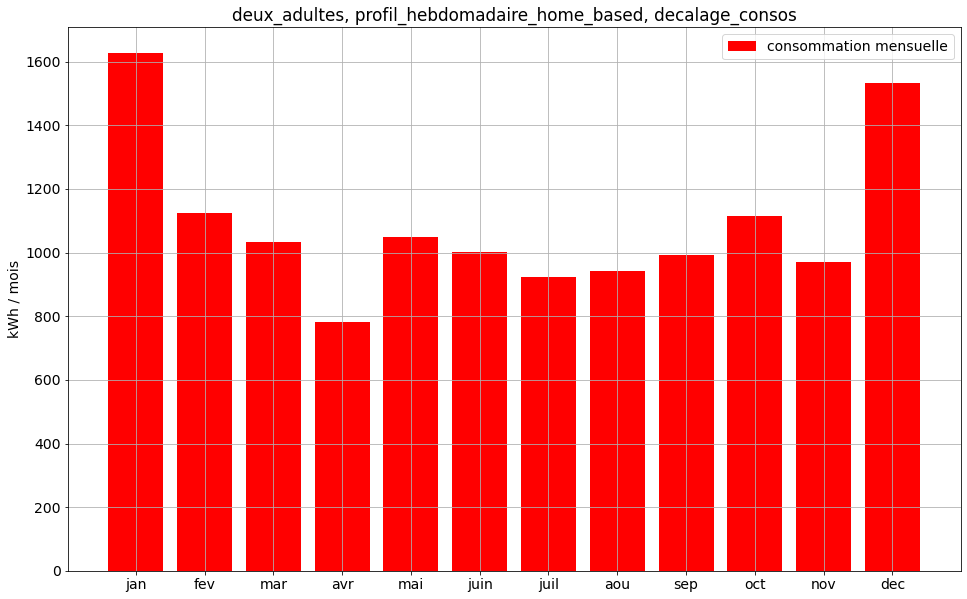

In [62]:
# consommation totale par mois

conso_m = consommation_annuelle_par_heure.resample('M').sum()
conso_m = conso_m[0]

fig, ax = plt.subplots(figsize=(16,10))
x = ['jan', 'fev', 'mar', 'avr', 'mai', 'juin', 'juil', 'aou', 'sep', 'oct', 'nov', 'dec']
ax.bar(x, height=conso_m, color='r', label='consommation mensuelle')
ax.set_ylabel(f"kWh / mois")

# plt.axhline(y=6000.0, color='k', label='6 kW DC')

# plt.axhline(y=5000.0, color='k', label='5 kW DC')

# plt.axhline(y=dc_max, color='b', label='DC max')
# plt.text(0, dc_max * .95,f"DC max = {dc_max:.0f} W")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

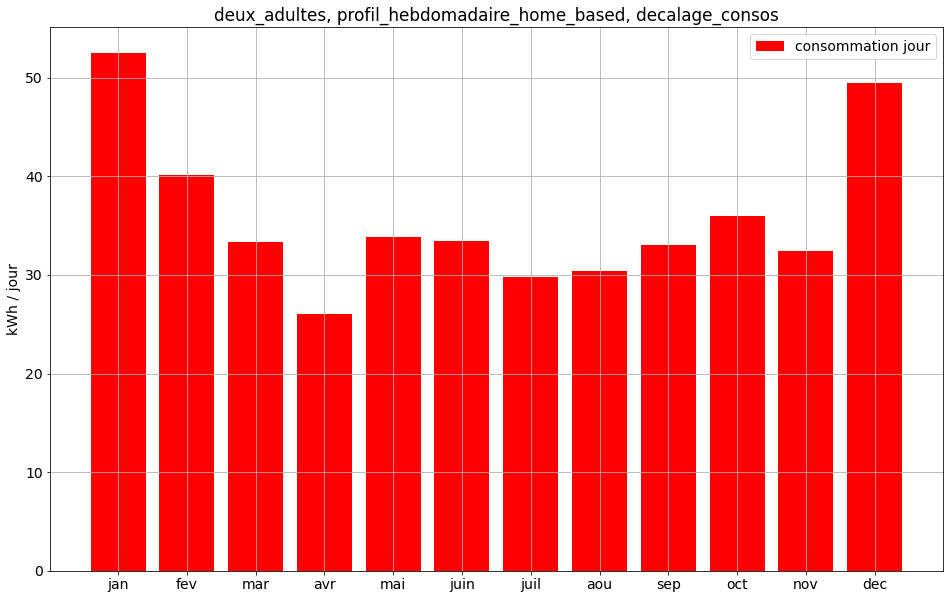

In [63]:
# consommation totale par jour

conso_d = consommation_annuelle_par_heure.resample('M').mean()
conso_d = conso_d[0] * 24

fig, ax = plt.subplots(figsize=(16,10))
x = ['jan', 'fev', 'mar', 'avr', 'mai', 'juin', 'juil', 'aou', 'sep', 'oct', 'nov', 'dec']
ax.bar(x, height=conso_d, color='r', label='consommation jour')
ax.set_ylabel(f"kWh / jour")

# fig, ax = plt.subplots(figsize=(16,10))
# ax.plot(conso_d, color='r', label='consommation jour')
# ax.set_ylabel(f"kWh / h")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

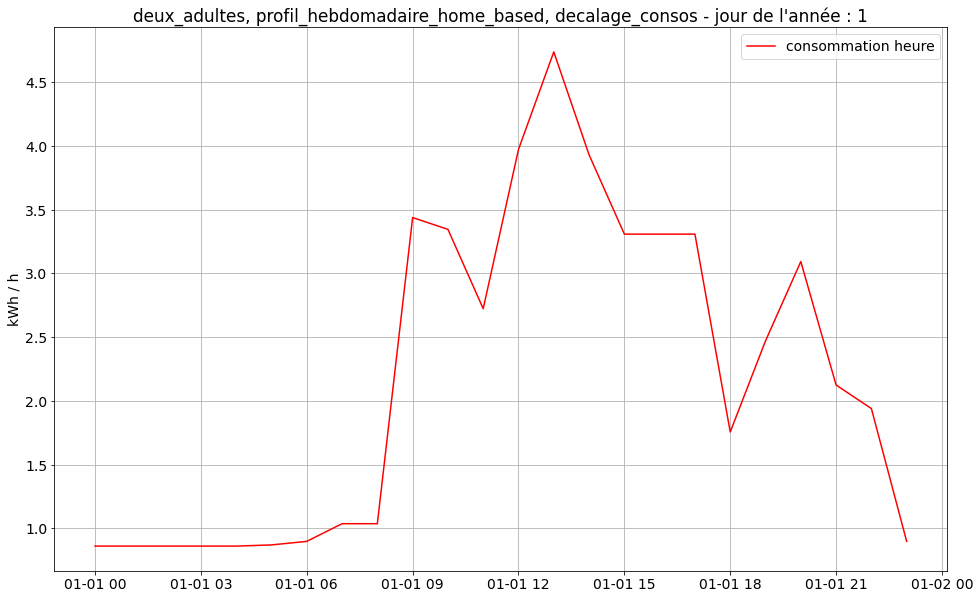

In [64]:
# consommation totale par heure : exemple 1er Janvier

conso_h = consommation_annuelle_par_heure

jour = 0
conso_h = conso_h[0][jour*24:(jour+1)* 24]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(conso_h, color='r', label='consommation heure')
ax.set_ylabel(f"kWh / h")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')} - jour de l'année : {jour+1}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

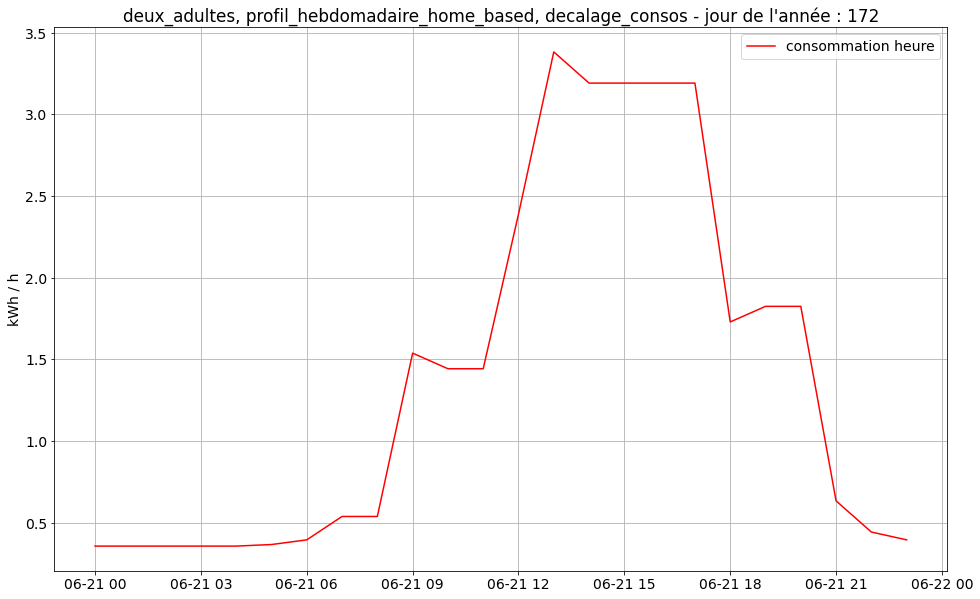

In [65]:
# consommation totale par heure : exemple 21 juin

conso_h = consommation_annuelle_par_heure

jour = 171
conso_h = conso_h[0][jour*24:(jour+1)* 24]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(conso_h, color='r', label='consommation heure')
ax.set_ylabel(f"kWh / h")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')} - jour de l'année : {jour+1}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

In [66]:
# panorama des consos par rubrique

df1 = pd.DataFrame.from_dict(consommations_jour)  # df des 365 jours x 9 consos nettes journalières de chaque rubrique

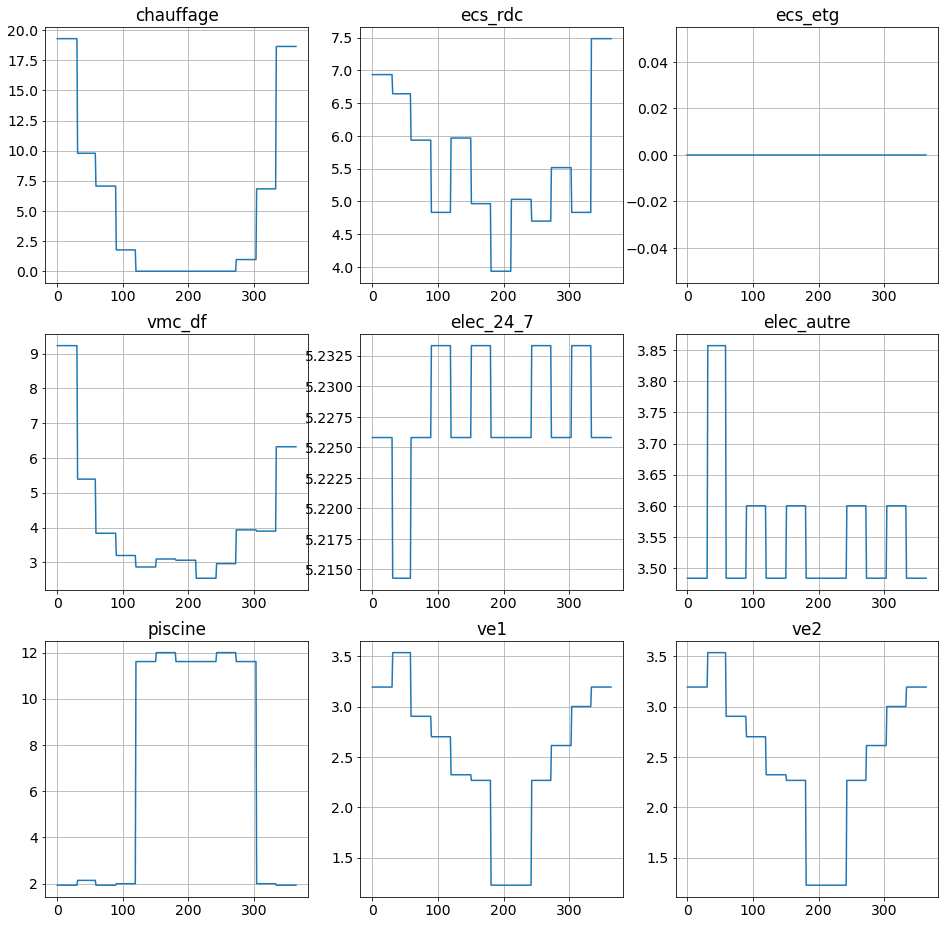

In [67]:
fig, ax = plt.subplots(3,3, figsize=(16,16))
rubriques = df1.columns

for i, r in enumerate(rubriques):
    rg = i // 3
    col = i % 3
    ax[rg,col] = df1[r].plot(ax = ax[rg,col])
    ax[rg,col].set_title(f"{r}")
    ax[rg,col].grid()

plt.show()

# Flux et Stockage

In [68]:
print (f"PRODUCTION")
print (f"Ensoleillement total POA = {dfs_poa.get(tilt_choisi)['poa_global'].sum()/1000.0:.0f} kWh/m²")
print (f"Modèle = {tilt_choisi}")
print (f"méthode montage = {methode}")
print (f"Puissance DC = {nameplate:.0f} Wc")
print (f"Puissance onduleur = {ac0:.0f} kVA, rendement = {eta:.1%}")
print (f"Prod AC totale annuelle = {ac.sum()/1000:.0f} kWh")

print (f"\n")
print (f"CONSOMMATION")
print (f"Scenario = {scenario.get('consommations_mensuelles').get('nom')}")
print (f"Profil activité = {scenario.get('profil_hebdomadaire').get('nom')}")
print (f"Profil horaire = {scenario.get('profil_horaire').get('nom')}")
print (f"Consommation totale annuelle = {consommation_annuelle_par_heure[0].sum():.0f} kWh" )

PRODUCTION
Ensoleillement total POA = 1357 kWh/m²
Modèle = horizontal_tilt_0
méthode montage = close_mount_glass_glass
Puissance DC = 7290 Wc
Puissance onduleur = 6000 kVA, rendement = 98.0%
Prod AC totale annuelle = 9034 kWh


CONSOMMATION
Scenario = deux_adultes
Profil activité = profil_hebdomadaire_home_based
Profil horaire = decalage_consos
Consommation totale annuelle = 13090 kWh


In [69]:
prod = ac / 1000.0  # production horaire en kWh
conso = consommation_annuelle_par_heure[0]  # consommation horaire en kWh

flux = pd.DataFrame(prod - conso)
flux.rename(columns = {0:'flux'}, inplace=True)

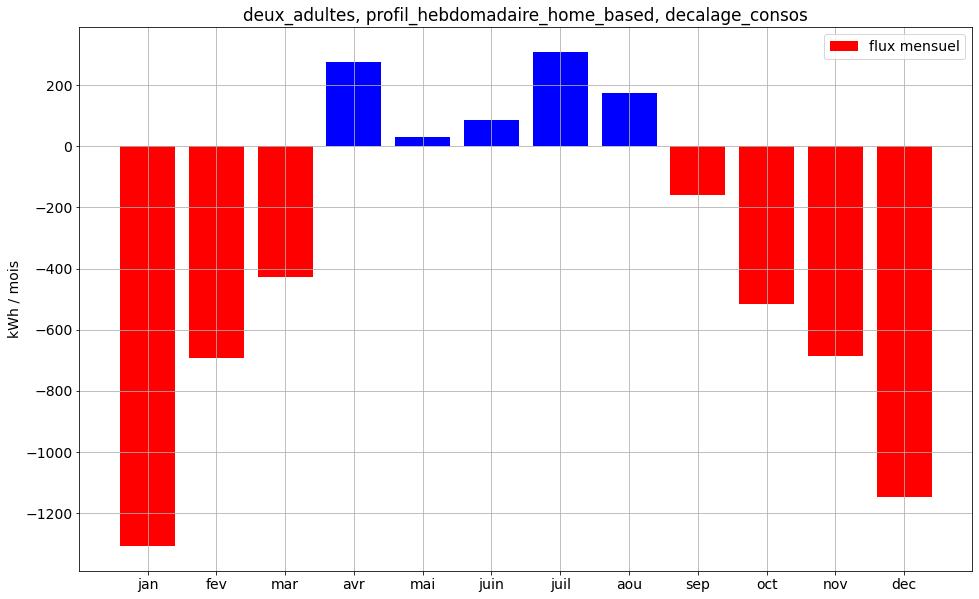

In [70]:
# flux par mois

flux_m = flux.resample('M').sum()
flux_m = flux_m['flux']

fig, ax = plt.subplots(figsize=(16,10))
x = ['jan', 'fev', 'mar', 'avr', 'mai', 'juin', 'juil', 'aou', 'sep', 'oct', 'nov', 'dec']
couleur = [ 'b' if f>=0.0 else 'r' for f in flux_m ]
ax.bar(x, height=flux_m, color=couleur, label='flux mensuel')
ax.set_ylabel(f"kWh / mois")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

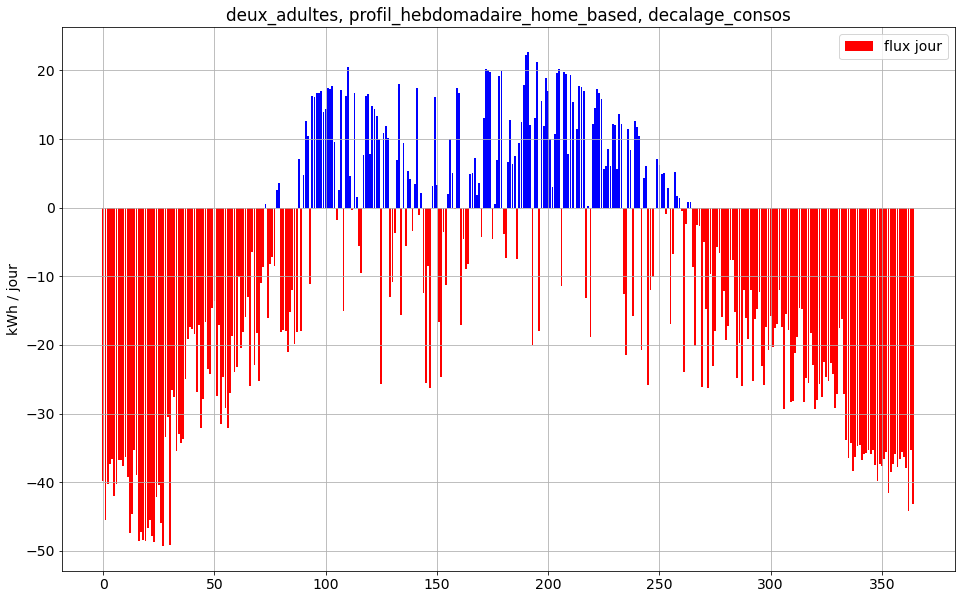

In [71]:
# flux par jour

flux_m = flux.resample('D').sum()
flux_m = flux_m['flux']

fig, ax = plt.subplots(figsize=(16,10))
x = range(365)
couleur = [ 'b' if f>=0.0 else 'r' for f in flux_m ]
ax.bar(x, height=flux_m, color=couleur, label='flux jour')
ax.set_ylabel(f"kWh / jour")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

In [72]:
fx = np.array(flux['flux'])
fx.shape

(8760,)

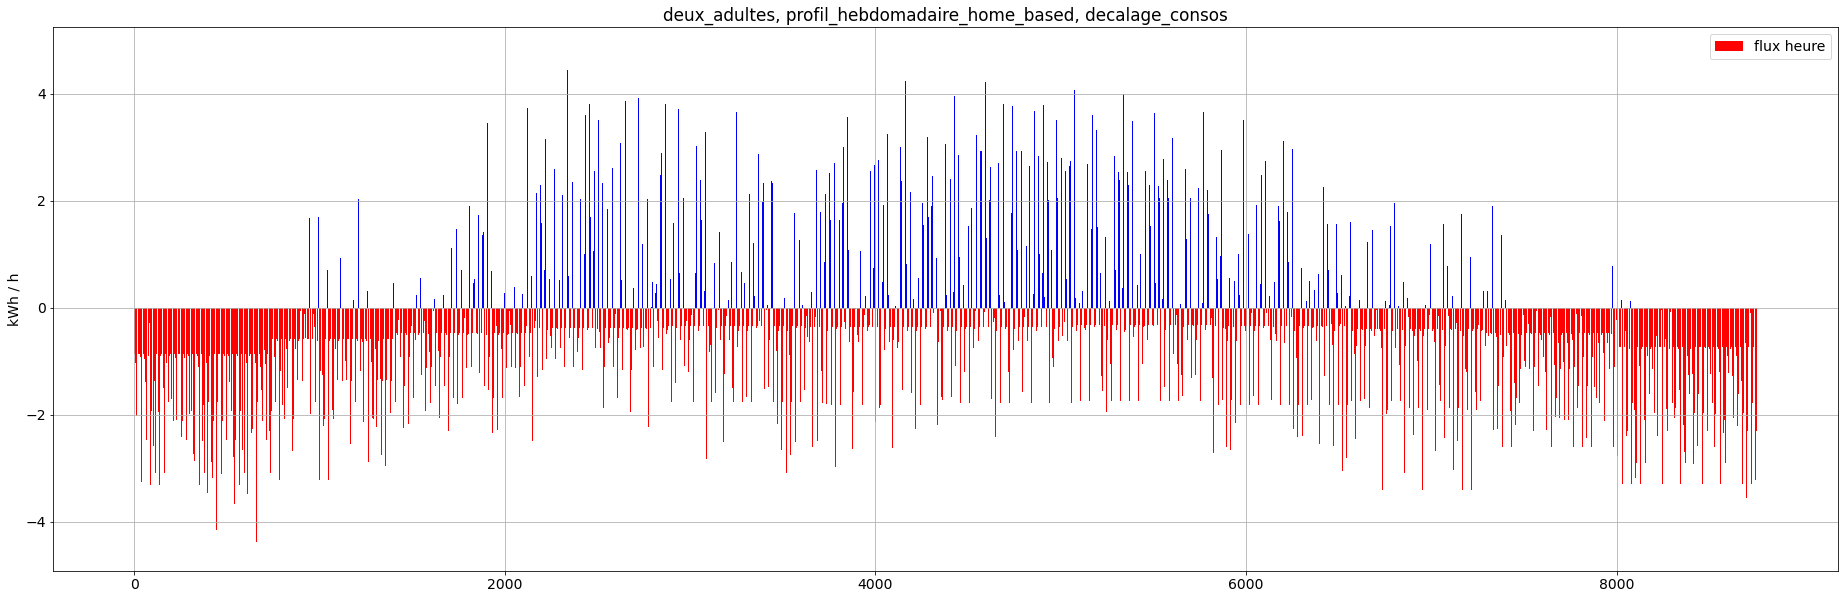

In [73]:
# flux par heure

fig, ax = plt.subplots(figsize=(32,10))

x = range(8760)
flux_array = np.array(flux['flux'])

couleur = [ 'b' if f>=0.0 else 'r' for f in list(flux_array) ]
ax.bar(x, height=flux_array, color=couleur, label='flux heure')
ax.set_ylabel(f"kWh / h")

plt.title(f"{scenario.get('consommations_mensuelles').get('nom')}, {scenario.get('profil_hebdomadaire').get('nom')}, {scenario.get('profil_horaire').get('nom')}") # onduleur {ac0:.0f} VA")

plt.legend()
plt.grid()
plt.show()

In [74]:
print(f"BILAN FLUX")
inj = np.where( flux_array > 0, flux_array, 0.0).sum()
print(f"injectés ou stockés : {inj:.0f} kWh")
print(f"from grid ou déstockés : {np.where( flux_array <= 0, flux_array, 0.0).sum():.0f} kWh")
autoconso = ac.sum()/1000.0 - inj
print(f"prod PV consommée : {autoconso:.0f} kWh")

BILAN FLUX
injectés ou stockés : 3243 kWh
from grid ou déstockés : -7299 kWh
prod PV consommée : 5791 kWh


# Etude STOCKAGE

In [75]:
# assemble la dataframe des productions et consommations horaires en Wh

df_data_horaire = pd.DataFrame(
    data={'production' : ac.values,
          'consommation' :consommation_annuelle_par_heure[0].to_numpy() * 1000.0
          },
    index=ac.index
    )

In [76]:
df_data_horaire['flux'] = df_data_horaire['production'] - df_data_horaire['consommation']

In [77]:
new_columns = [
    'from_grid',  # flux du jour éventuellement tiré de la grille. NB : valeurs >= 0
    'from_stockage_virtuel', # flux du jour éventuellement tiré du stockage virtuel. NB : valeurs >= 0
    'from_batterie', # flux du jour éventuellement tiré de la batterie. NB : valeurs >= 0
    'soc_batterie', # state of charge de la batterie au début de la tranche horaire
    'soc_stockage_virtuel', # state of charge (=valeur compteur) du stockage virtuel
    'to_batterie', # flux éventuellement stocké dans la batterie (valeur >=0), à concurrence de soc_batterie <= capacité_batterie
    'to_stockage_virtuel', # flux éventuellement stocké (compté) dans stockage virtuel (valeur >=0), à concurrence de soc_stockage_virtuel <= capacité_stockage_virtuel
    'to_grid', # flux éventuellement injecté (>=0)
]

df_data_horaire[new_columns] = 0.0

In [78]:
def allocation_flux(
    production,
    consommation,
    
    stockage_batterie,
    soc_batterie,
    capacite_batterie, 
    
    stockage_virtuel,
    soc_stockage_virtuel,
    capacite_stockage_virtuel
    ):
    
    """Prend la production et la consommation du pas horaire, les données des différents stockages, et retourne l'allocation du flux dans les différentes rubriques.T
    
    Inputs :
    --------
    production (float) : production du pas horaire
    consommation (float) : consommation du pas horaire
    
    stockage_batterie (bool) : indique si un stockage batterie est disponible ou pas
    soc_batterie (float) : charge de la batterie avant traitement (Wh)
    capacite_batterie (float) : capacité utile max de la batterie (Wh)
    
    stockage_virtuel (float) : indique si un stockage virtuel est disponible ou pas
    soc_stockage_virtuel (float) : valeur du compteur (=soc) du stockage virtuel
    capacite_stockage_virtuel (float) : capacité utile max du stockage virtuel (a priori non cappée)
    
    Returns:
    --------
    from_grid (float >=0) : énergie tirée du réseau (Wh), 
    from_stockage_virtuel (float >=0) : énergie déstockée du stockage virtuel (Wh)
    from_batterie (float >=0) : énergie déstockée de la batterie (Wh)
    new_soc_batterie (float >=0) : charge batterie après traitement de production/consommation (Wh)
    new_soc_stockage_virtuel (float >=0) : charge (compteur) du stockage virtuel après traitement de production/consommation (Wh)
    to_batterie (float >=0) : énergie stockée dans la batterie (Wh)
    to_stockage_virtuel (float >=0) : énergie stockée (comptée) dans le stockage virtuel (Wh)
    to_grid (float>=0) : énergie injectée sur le réseau (Wh)
    """
    
    flux = production - consommation
    
    if flux >= 0:
        
        # production supérieure à la consommation
        
        # 1/ aucun supply nécessaire
        from_grid = 0.0
        from_stockage_virtuel = 0.0
        from_batterie = 0.0
        
        # 2/ allocation dans les différents stockages
        reste = flux
        
        # 2.1/ si on dispose d'une batterie :
        if stockage_batterie:
            to_batterie = min(reste, capacite_batterie-soc_batterie) # on stocke jusqu'à la capacité max de la batterie
            new_soc_batterie = soc_batterie + to_batterie
            reste -= to_batterie
        else:
            to_batterie = 0.0
            new_soc_batterie = soc_batterie
            
        # 2.2/ si on dispose d'un stockage virtuel :
        if stockage_virtuel:
            to_stockage_virtuel = min(reste, capacite_stockage_virtuel-soc_stockage_virtuel) # on stocke jusqu'à la capacité max du stockage virtuel
            new_soc_stockage_virtuel = soc_stockage_virtuel + to_stockage_virtuel
            reste -= to_stockage_virtuel
        else:
            to_stockage_virtuel = 0.0
            new_soc_stockage_virtuel = soc_stockage_virtuel
            
        # 2.3/ ce qui reste est injecté sur le réseau
        to_grid = reste
        
    else:
        
        # production inférieure à la consommation
        
        # 1/ aucun stockage possible
        to_grid = 0.0
        to_stockage_virtuel = 0.0
        to_batterie = 0.0
        
        # 2/ allocation depuis les différentes sources
        reste = -flux # besoin >= 0
        
        # 2.1/ si on a une batterie, on essaie de déstocker
        if stockage_batterie:
            from_batterie = min(reste, soc_batterie) # on déstocke jusqu'à épuisement de l'énergie disponible
            new_soc_batterie = soc_batterie - from_batterie
            reste -= from_batterie
        else:
            from_batterie = 0.0
            new_soc_batterie = soc_batterie
            
        # 2.2/ si on dispose d'un stockage virtuel 
        if stockage_virtuel:
            from_stockage_virtuel = min(reste, soc_stockage_virtuel) # on déstocke jusqu'à épuisement du stockage virtuel
            new_soc_stockage_virtuel = soc_stockage_virtuel - from_stockage_virtuel
            reste -= from_stockage_virtuel
        else:
            from_stockage_virtuel = 0.0
            new_soc_stockage_virtuel = soc_stockage_virtuel
            
        # 2.3/ le besoin restant est tiré du réseau
        from_grid = reste

    return from_grid, from_stockage_virtuel, from_batterie, new_soc_batterie, new_soc_stockage_virtuel, to_batterie, to_stockage_virtuel, to_grid

In [79]:
# TESTS DE LA FONCTION ALLOCATION

cas =[
    { 'production' : 1000.0, 'consommation' : 0.0, 'stockage_batterie' : False, 'soc_batterie' : 0.0, 'capacite_batterie' : 0.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    { 'production' : 1000.0, 'consommation' : 200.0, 'stockage_batterie' : False, 'soc_batterie' : 0.0, 'capacite_batterie' : 0.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    
    { 'production' : 1000.0, 'consommation' : 200.0, 'stockage_batterie' : True, 'soc_batterie' : 0.0, 'capacite_batterie' : 1000.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    { 'production' : 1000.0, 'consommation' : 200.0, 'stockage_batterie' : True, 'soc_batterie' : 0.0, 'capacite_batterie' : 500.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    
    { 'production' : 1000.0, 'consommation' : 200.0, 'stockage_batterie' : True, 'soc_batterie' : 0.0, 'capacite_batterie' : 500.0, 'stockage_virtuel' : True, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 1000.0 },
    { 'production' : 5000.0, 'consommation' : 1000.0, 'stockage_batterie' : True, 'soc_batterie' : 0.0, 'capacite_batterie' : 500.0, 'stockage_virtuel' : True, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 1000.0 },
    
    { 'production' : 1000.0, 'consommation' : 2000.0, 'stockage_batterie' : False, 'soc_batterie' : 0.0, 'capacite_batterie' : 0.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    
    { 'production' : 1000.0, 'consommation' : 2000.0, 'stockage_batterie' : True, 'soc_batterie' : 10000.0, 'capacite_batterie' : 10000.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    
    { 'production' : 1000.0, 'consommation' : 2000.0, 'stockage_batterie' : True, 'soc_batterie' : 600.0, 'capacite_batterie' : 10000.0, 'stockage_virtuel' : False, 'soc_stockage_virtuel' : 0.0, 'capacite_stockage_virtuel' : 0.0 },
    
    { 'production' : 1000.0, 'consommation' : 2000.0, 'stockage_batterie' : True, 'soc_batterie' : 100.0, 'capacite_batterie' : 10000.0, 'stockage_virtuel' : True, 'soc_stockage_virtuel' : 200.0, 'capacite_stockage_virtuel' : 1000.0 },
]  

expected = [
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :0.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 1000.0 },
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :0.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 800.0 },
    
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :800.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 800.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 0.0 },
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :500.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 500.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 300.0 },
    
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :500.0, 'new_soc_stockage_virtuel' : 300.0, 'to_batterie' : 500.0, 'to_stockage_virtuel' : 300.0, 'to_grid' : 000.0 },
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :500.0, 'new_soc_stockage_virtuel' : 1000.0, 'to_batterie' : 500.0, 'to_stockage_virtuel' : 1000.0, 'to_grid' : 2500.0 },
    
    { 'from_grid' : 1000.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 0.0, 'new_soc_batterie' :0.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 0.0 },
    
    { 'from_grid' : 0.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 1000.0, 'new_soc_batterie' : 9000.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 0.0 },
    
    { 'from_grid' : 400.0, 'from_stockage_virtuel' : 0.0, 'from_batterie' : 600.0, 'new_soc_batterie' : 0.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 0.0 },
    
    { 'from_grid' : 700.0, 'from_stockage_virtuel' : 200.0, 'from_batterie' : 100.0, 'new_soc_batterie' : 0.0, 'new_soc_stockage_virtuel' : 0.0, 'to_batterie' : 0.0, 'to_stockage_virtuel' : 0.0, 'to_grid' : 0.0 },
]

for i, (c,e) in enumerate(zip(cas, expected)):
    # print(f"\ncas {i+1}")
    attendu = tuple(e.values())
    # print(f"attendu = {attendu}")
    resultat = allocation_flux(**c)
    # print(f"résultat = {resultat}")
    # print(f"{attendu == resultat}")
    assert attendu == resultat, f"cas {i+1} : \nattendu = {attendu}, \nresultat = {resultat}"

In [80]:
df_data_horaire

,production,consommation,flux,from_grid,from_stockage_virtuel,from_batterie,soc_batterie,soc_stockage_virtuel,to_batterie,to_stockage_virtuel,to_grid
2023-01-01 00:00:00+00:00,0.0,860.298963,-860.298963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00+00:00,0.0,860.298963,-860.298963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00+00:00,0.0,860.298963,-860.298963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00+00:00,0.0,860.298963,-860.298963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00+00:00,0.0,860.298963,-860.298963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,0.0,2307.438602,-2307.438602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 20:00:00+00:00,0.0,2908.895418,-2908.895418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 21:00:00+00:00,0.0,1961.327539,-1961.327539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 22:00:00+00:00,0.0,1776.506798,-1776.506798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# paramètres de stockage

stockage = {
    'stockage_batterie' : True, # présence, ou pas, d'une batterie de stockage
    'capacité_batterie' : 11000, # capacité totale utile de la batterie, en Wh
    'stockage_virtuel' : True, # présence, ou pas, d'un stockage virtuel auprès d'un fournisseur d'énergie
    'capacité_stockage_virtuel' : 50000000, # capacité totale utile du stockage virtuel (arbitrairement haut)
}

In [138]:
stockage_batterie = stockage.get('stockage_batterie')
capacite_batterie = stockage.get('capacité_batterie')
stockage_virtuel = stockage.get('stockage_virtuel')
capacite_stockage_virtuel = stockage.get('capacité_stockage_virtuel')

In [139]:
new_soc_batterie = 0.0
new_soc_stockage_virtuel = 0.0

for d in tqdm(df_data_horaire.index):
    df_data_horaire.loc[d, 'soc_batterie'] = new_soc_batterie  # soc batterie avant traitement du flux horaire
    df_data_horaire.loc[d, 'soc_stockage_virtuel'] = new_soc_stockage_virtuel  # compteur stockage virtuel avant traitement du flux horaire
    
    production = df_data_horaire.loc[d, 'production']
    consommation = df_data_horaire.loc[d, 'consommation']
    soc_batterie = df_data_horaire.loc[d, 'soc_batterie']
    soc_stockage_virtuel = df_data_horaire.loc[d, 'soc_stockage_virtuel']    
    
    from_grid, from_stockage_virtuel, from_batterie, new_soc_batterie, new_soc_stockage_virtuel, to_batterie, to_stockage_virtuel, to_grid = allocation_flux(
        production = production,
        consommation = consommation,
        stockage_batterie = stockage_batterie,
        soc_batterie = soc_batterie,
        capacite_batterie = capacite_batterie,
        stockage_virtuel = stockage_virtuel,
        soc_stockage_virtuel = soc_stockage_virtuel,
        capacite_stockage_virtuel = capacite_stockage_virtuel
        )
    
    df_data_horaire.loc[d, 'from_grid'] = from_grid
    df_data_horaire.loc[d, 'from_stockage_virtuel'] = from_stockage_virtuel
    df_data_horaire.loc[d, 'from_batterie'] = from_batterie
    
    df_data_horaire.loc[d, 'to_batterie'] = to_batterie
    df_data_horaire.loc[d, 'to_stockage_virtuel'] = to_stockage_virtuel
    df_data_horaire.loc[d, 'to_grid'] = to_grid

100%|██████████| 8760/8760 [00:22<00:00, 386.94it/s]


In [140]:
print(f"parametres : {stockage}")

liste_colonnes = [
    'production',
    'consommation',
    'flux',
    'from_grid',
    'from_stockage_virtuel',
    'from_batterie',
    'to_batterie', 
    'to_stockage_virtuel',
    'to_grid'
]

for c in liste_colonnes:
    print(f"{c} = {df_data_horaire[c].sum()/1000.0:.0f} kWh/an")

parametres : {'stockage_batterie': True, 'capacité_batterie': 11000, 'stockage_virtuel': True, 'capacité_stockage_virtuel': 50000000}
production = 9034 kWh/an
consommation = 13090 kWh/an
flux = -4056 kWh/an
from_grid = 4056 kWh/an
from_stockage_virtuel = 1425 kWh/an
from_batterie = 1818 kWh/an
to_batterie = 1818 kWh/an
to_stockage_virtuel = 1425 kWh/an
to_grid = 0 kWh/an


<AxesSubplot:>

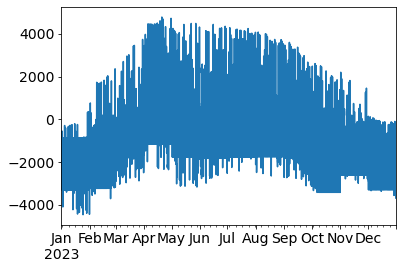

In [136]:
df_data_horaire['flux'].plot()

<AxesSubplot:>

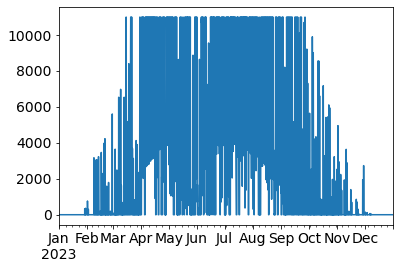

In [135]:
df_data_horaire['soc_batterie'].plot()

<AxesSubplot:>

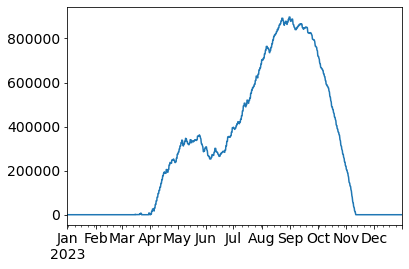

In [141]:
df_data_horaire['soc_stockage_virtuel'].plot()

### 1- ANNEXES DATA

In [85]:
#-----------------------------------------------------------------------------------------------------
# données module Trina : sources = datasheet Trina, base CEC, autres info reprises de la db SAM
#-----------------------------------------------------------------------------------------------------

module_trina_vertex_405 = {
    "Vintage" : 2021,  # datasheet info
    "Area" : 1.91,
    "Material" : "Mono-c-Si", # datasheet info
    "Cells_in_Series" : 60, # CEC database info
    "Parallel_Strings" : 2, # CEC database info
    "Isco" : 12.34, # short circuit current : datasheet info
    "Voco" : 41.4, # open circuit voltage : datasheet info
    "Impo" : 11.77, # max power current : datasheet info
    "Vmpo" : 34.4, # max power voltage : datasheet info
    "Aisc" : 0.0004, # short circuit temperature coefficient : datasheet info plus pénalisante que CEC info
    "Aimp" : 0.0004, # maximum power temperature coefficient : inconnu, on reconduit Aisc
    "C0" : 1.01284, # coefficients relating Im p to G : ?
    "C1" : -0.01284, # coefficients relating Im p to G : ?
    "Bvoco" : -0.266, # open circuit temperature coefficient : CEC info plus pénalisante que datasheet info 
    "Mbvoc" : 0, # relates βoc,re f to effective irradiance : 0 ?
    "Bvmpo" : -0.266, # maximum power voltage temperature coefficient : inconnnu, on reconduit Bvoco
    "Mbvmp" : 0, # relates βm p,re f to effective irradiance : 0 ?
    "N" : 1.4032, # diode factor : ?
    "C2" : 0.279317, # coefficients relating Vm p to G : ?
    "C3" : -7.24463, # coefficients relating Vm p to G : ?
    "A0" : 0.928385, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A1" : 0.068093, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A2" : -0.015774, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A3" : 0.001661, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A4" : -0.000069, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "B0" : 1, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B1" : -0.002438, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B2" : 0.00031, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B3" : -0.000012, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B4" : 0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B5" : -0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "DTC" : 3.0, # ??
    "FD" : 1, # fraction of diffuse irradiance used by module
    "A" : -3.40641, # ??
    "B" : -0.084208, # ??
    "C4" : 0.996446, # coefficients relating Ix to G : ?
    "C5" : 0.003554, # coefficients relating Ix to G : ?
    "IXO" : 4.97599, # ?
    "IXXO" : 3.18803, # ?
    "C6" : 1.15535, # coefficients relating Ixx to G : ?
    "C7" : -0.155353, # coefficients relating Ixx to G : ?
    "Notes" : "Format SAM model, Source: CEC database, 11-Aug-2022",
    "Name" : "Trina_Vertex_405Wc_TSM-DE09"
}

In [86]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur Référence : SMA Tripower 8.0 -----------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tri_TL_8kVA = {
    "Vac" : 480.0, # Nominal voltage, -- inchangé -- essai à 230 : non, essai à 380 neg ; essai à 480
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power - ok
    "Pdco" : 15000.0, # Maximum DC power - changé de 12000 à 15000
    "Vdco" : 580.0, # Nominal DC voltage - changé de 600 à 580
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage -- ok
    "Idcmax" : 20.0, # Maximum DC current -- ok
    "Mppt_low" : 260.0, # min MPP voltage -- changé de 330 à 260
    "Mppt_high" : 800.0, # max MPP voltage -- inchangé
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [87]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur SMA Tripower Smart Energy --------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tripower_sme = {
    "Vac" : 230.0, # Nominal voltage,
    "Pso" : 44.0, # Power consumption during operation
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 12000.0, # Maximum DC power
    "Vdco" : 600.0, # Nominal DC voltage
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "Pnt" : 0.075, # Inverter night time loss : ?
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 20.0, # Maximum DC current
    "Mppt_low" : 330.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [88]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur custom ---------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_custom = {
    "Vac" : 380.0, # Nominal voltage, 
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 15000.0, # Maximum DC power
    "Vdco" : 580.0, # Nominal DC voltage
    "C0" : -1e-6, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 30.0, # Maximum DC current
    "Mppt_low" : 260.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [89]:
# # module, onduleur...

# sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
# sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# # module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
# module = pd.Series(module_trina_vertex_405)
# # inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
# inverter = pd.Series(inverter_sma_tripower_sme)

# inverter_ref = sapm_inverters['SMA_America__STP12000TL_US_10__480V_']  # SMA Tri 12kVA
# module_ref = sandia_modules['Suniva_Titan_240__2009__E__']   # module ancien à 240 Wc

# temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [90]:
# sandia_modules.transpose().to_csv('../Databases/sandia_modules.csv')  # dernier update = 2012 ?!
# sapm_inverters.transpose().to_csv('../Databases/sapm_inverters.csv')  # dernier update = 

In [91]:
# module = module_trina_vertex_405
# inverter = inverter_sma_tri_ref_8kVA

In [92]:
# # Design PV OOP

# from pvlib.pvsystem import PVSystem, Array, FixedMount
# from pvlib.location import Location
# from pvlib.modelchain import ModelChain

# energies = {}

# for location, weather in zip(coordinates, tmys):
#     latitude, longitude, name, altitude, timezone = location
    
#     location = Location(
#         latitude,
#         longitude,
#         name=name,
#         altitude=altitude,
#         tz=timezone,
#     )
    
#     mount = FixedMount(surface_tilt=0.0, surface_azimuth=180.0)
    
#     array = Array(
#         mount=mount,
#         module_parameters=module,
#         temperature_model_parameters=temperature_model_parameters,
#         modules_per_string=21,
#         strings=1
#     )
    
#     system = PVSystem(arrays=[array], inverter_parameters=inverter)
    
#     mc = ModelChain(system, location,
#                     spectral_model='no_loss',  # on essaie spectral model = no loss...
#     )
    
#     mc.run_model(weather)
#     annual_energy = mc.results.ac.sum()
    
#     energies[name] = annual_energy

# energies = pd.Series(energies)

# energies.plot(kind='bar', rot=0)

# plt.ylabel('Yearly energy yield (W hr)')